============ Datathon INSTRUCTIONS and INFORMATION ============

Challenge: SkyHigh Books want to know in 2018 what readers will rate their books that they publish. You are given data from 2017, where you know what readers read and what rating each user provided on average to all books they read.

Your job is 4 fold:

Predict what readers will rate on average in 2018 on all books they will read in 2017 + 2018. Use the wishlist of books readers want to read in 2018 and what they have already read in 2017 as a starting point. SkyHigh Books wants to know this information, as they want to market directly to readers who either have higher potential average scores on all books, or lower scores.

SkyHigh Books wants to know why some books in 2017 or 2018 (predict which books) have good or bad overall ratings. Is it certain words in the book? The genre of the book? The price in 2017 / 2018? Where it was sold? Why do some books on average have a higher rating than other books?

SkyHigh Books wants to maintain a good online presence on book review sites (hence we want to predict user averages), and so they want you to tell them how they can lift overall global reader satisifcation (not just each individual user, but overall).

Provide confidence bounds on your predictions. How much % are you sure your predictions are true or correct? Is the results plausible? Does the data seem plausible? (Ie do the word count follow some Power Law Distribution?)

**Datasets**

You are provided with 6 datasets:

1. **Books Information**
2. **Genres Mapping**
3. **User Data**
4. **Words in Book**
5. **Words Mapping**
6. **Example Submissions**

------

1. **Books Information** Actual info on books. Book ID, Barcode, difficulty (average *perceieved* reading difficulty of book --> 1 = easy, 5 = hard).
2. **Genres Mapping** Maps Genre IDs to real Genre types (eg Science)
3. **User Data** User's data on average ratings and what they read in 2017 + wishlist for 2018.
4. **Words in Book** What are the words in the actual book.
5. **Words Mapping** Actual words mapped to word ID
6. **Example Submissions** Shows an example of what you need to provide.

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn import datasets, metrics
from surprise.model_selection import GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pyplot as plt

from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor



In [2]:
## loading data
Books_Information = pd.read_csv('Books information.csv')
User_Data = pd.read_csv('User Data.csv').replace("Not specified", np.nan)



In [71]:
User_Data.head()

,User ID,User Difficulty Choice,User Read Books (2017),User Read Books (2018),Average Rating (2017)
0,ID790145788,1,6254,7180,3.115447
1,ID646234447,NaN,"5854, 5676, 7265, 6051","5729, 5279, 6242, 5519, 5251",3.157876
2,ID86918707,5,5815,"6372, 6697",1.512284
3,ID404262345,2,"6969, 7002, 5761","5023, 6412, 6124",3.641681
4,ID267634255,4,"7908, 7585, 7655, 5013, 5352, 7753, 5793","7915, 7884, 7404, 6022, 6589, 6543, 5450, 6848",2.506743


In [70]:
Books_Information.head()

,Book ID,Book Genre,Barcode,Difficulty (Reader suggested),Number Of Words,Price (2017),Price (2018),Most Sold At,Number Sold
0,5000,24,#24-349283,2,937,32.546216,34.030877,Daniel's Bookshop,2789
1,5001,30,#30-441083,1,4258,12.955205,13.122562,Daniel's Bookshop,411
2,5002,26,#26-417947,2,4063,7.793854,8.311120,DHC-Online,4282
3,5003,19,#19-346900,5,2868,9.871150,10.156169,Level 5 Daniel Shop,3294
4,5004,21,#21-349180,2,4622,44.802459,46.369520,Daniel's Bookshop,739


In [ ]:
Books_Information.isnull().sum()

In [3]:
user_2017 = User_Data.iloc[:, [0, 1, 2, 4]]
arr_2017 = [[columns[0], columns[1], int(book), float(columns[3])] for columns in user_2017.values for book in columns[2].split(', ')]
user_2017 = pd.DataFrame(arr_2017, columns=user_2017.columns)

user_2018 = User_Data.iloc[:, [0, 1, 3]]
arr_2018 = [[columns[0], columns[1], int(book)] for columns in user_2018.values for book in columns[2].split(', ')]
user_2018 = pd.DataFrame(arr_2018, columns=user_2018.columns)

In [4]:
df_2017 = user_2017.merge(Books_Information, left_on='User Read Books (2017)', right_on='Book ID')
df_2018 = user_2018.merge(Books_Information, left_on='User Read Books (2018)', right_on='Book ID')

df_2017 = df_2017[["User ID", "User Read Books (2017)", "User Difficulty Choice", "Book Genre", "Difficulty (Reader suggested)", "Number Of Words", "Price (2017)", "Most Sold At", "Number Sold", "Average Rating (2017)"]].rename(columns={'User Read Books (2017)': 'Book', 'Price (2017)': 'Price', 'Average Rating (2017)': "Rating"})
df_2018 = df_2018[["User ID", "User Read Books (2018)", "User Difficulty Choice", "Book Genre", "Difficulty (Reader suggested)", "Number Of Words", "Price (2018)", "Most Sold At", "Number Sold"]].rename(columns={'User Read Books (2018)': 'Book', 'Price (2018)': 'Price'})

In [5]:
X = df_2017.iloc[:, 2:8].values
y = df_2017.iloc[:, -1].values

In [6]:
# Taking care of missing data

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X[:, 0].reshape(-1, 1))
X[:, 0] = imputer.transform(X[:, 0].reshape(-1, 1)).round().reshape(-1, )

In [7]:

labelencoder = LabelEncoder()
X[:, 5] = labelencoder.fit_transform(X[:, 5])
onehotencoder = OneHotEncoder(categorical_features = [1, 5])
X = onehotencoder.fit_transform(X).toarray()

In [ ]:
'''# feature scaling

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)
sc_y = StandardScaler()
y = sc_y.fit_transform(y.reshape(-1, 1))
'''

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
# import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge





In [36]:
n_folds = 10
def CV_RMSE(model):
    kf = KFold(n_folds, shuffle=True)
    scores = np.sqrt(-cross_val_score(model, X, y, cv=kf.get_n_splits(X), scoring='neg_mean_squared_error'))
#     print("RMSE Score:", scores)
    return scores


In [32]:
CV_RMSE(ENet)

RMSE Score: [ 1.60080028  1.62995381  1.57535839  1.63785111  1.58602551  1.62615024
  1.63592135  1.65177208  1.65464984  1.64623564]


array([ 1.60080028,  1.62995381,  1.57535839,  1.63785111,  1.58602551,
        1.62615024,  1.63592135,  1.65177208,  1.65464984,  1.64623564])

In [66]:
ridge = Ridge(alpha=0.0001)
lasso = Lasso(alpha=0.0001)
elasticnet = ElasticNet(alpha=0.0001)
CV_RMSE(ridge)


array([ 1.60079593,  1.62981127,  1.57549311,  1.63827308,  1.58660713,
        1.62757239,  1.63661912,  1.65234423,  1.65519918,  1.64646906])

In [67]:
CV_RMSE(lasso)


array([ 1.60077537,  1.6298308 ,  1.57546099,  1.63819141,  1.58648075,
        1.62723908,  1.63645698,  1.65222801,  1.65507124,  1.64639432])

In [68]:
alpha_ranges = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]

alpha_scores = []
for alpha in alpha_ranges:
    model = ElasticNet(alpha=alpha)

    scores = CV_RMSE(model)
    print(alpha, scores.mean())
    alpha_scores.append(scores.mean())
print(alpha_scores)



0.0001 1.62485842486
0.0002 1.62480212017
0.0003 1.6247476161
0.0004 1.62469397542
0.0005 1.62463987181
[1.6248584248618279, 1.6248021201718479, 1.6247476160988346, 1.6246939754229488, 1.6246398718143436]


Text(0,0.5,'Cross-Validated RMSE')

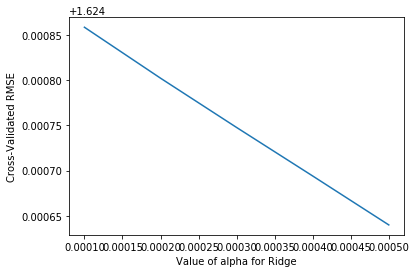

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(alpha_ranges, alpha_scores)
plt.xlabel('Value of alpha for Ridge')
plt.ylabel('Cross-Validated RMSE')

In [21]:
# LASSO Regression :
lasso = Lasso(alpha=0.0005, random_state=1)
# Elastic Net Regression
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
# Gradient Boosting Regression
GBoost = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=4,
    max_features='sqrt',
    min_samples_leaf=15,
    min_samples_split=10,
    loss='huber',
    random_state=5)
#  XGboost
model_xgb = xgb.XGBRegressor(
    colsample_bytree=0.4603,
    gamma=0.0468,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=1.7817,
    n_estimators=2200,
    reg_alpha=0.4640,
    reg_lambda=0.8571,
    subsample=0.5213,
    silent=1,
    random_state=7,
    nthread=-1)

# Base models scores
score = CV_RMSE(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = CV_RMSE(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(KRR)
# print(
#     "Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = CV_RMSE(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(),
                                                          score.std()))
score = CV_RMSE(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(model_lgb)
# print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

RMSE: [ 1.61632338  1.60748831  1.60734089  1.6440666   1.65162396]

Lasso score: 1.6254 (0.0188)

RMSE: [ 1.61631936  1.6075284   1.60742205  1.64412711  1.65164233]
ElasticNet score: 1.6254 (0.0188)

RMSE: [ 1.6518184   1.65145998  1.62799842  1.69521513  1.67662206]
Gradient Boosting score: 1.6606 (0.0231)

RMSE: [ 1.63741471  1.63089523  1.62103093  1.67773497  1.66849469]
Xgboost score: 1.6471 (0.0221)



In [12]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack(
            [model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)


In [13]:
# 评价这四个模型的好坏
averaged_models = AveragingModels(models=(ENet, GBoost, model_xgb, lasso))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(),
                                                              score.std()))


rmse [ 1.57907632  1.62784551  1.61759573  1.60291609  1.59664893]
 Averaged base models score: 1.6048 (0.0169)



In [14]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # Do the predictions of all base models on the test data and use the averaged predictions as
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(
                axis=1) for base_models in self.base_models_
        ])
        return self.meta_model_.predict(meta_features)



In [15]:

stacked_averaged_models = StackingAveragedModels(
    base_models=(ENet, GBoost, model_xgb), meta_model=lasso)
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(),
                                                               score.std()))

rmse [ 1.57978812  1.62599699  1.61877575  1.6017092   1.59741854]
Stacking Averaged models score: 1.6047 (0.0163)


In [18]:
clone(lasso)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [ ]:
rmsle_cv(5, BaggingRegressor(base_estimator=ridge, n_estimators=param))

In [ ]:
params = [1, 10, 20, 40, 60]
test_scores = []
for param in params:
    clf = BaggingRegressor(base_estimator=ridge, n_estimators=param)
    # cv=5表示cross_val_score采用的是k-fold cross validation的方法，重复5次交叉验证
    # scoring='precision'、scoring='recall'、scoring='f1', scoring='neg_mean_squared_error' 方差值
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train.ravel(), cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
print(test_score.mean())
plt.plot(params, test_scores)
plt.title('CV Error vs No. estimators')
plt.show()


In [ ]:
KFold(5, shuffle=True, random_state=42).get_n_splits(X_train)

In [ ]:
cross_val_score

In [ ]:
#Validation function
n_folds = 5


def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(
        model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf.get_n_splits(train.values)))
    print("rmse", rmse)
    return (rmse)